In [1]:
# import os

# # Set R environment variables using the conda environment path
# r_home = '/sfs/gpfs/tardis/home/jq2uw/llm_nicu_vitalsigns/clip_env/lib/R'
# os.environ['R_HOME'] = r_home
# os.environ['R_LIBS'] = f"{r_home}/library"
# os.environ['R_LIBS_USER'] = os.path.expanduser('~/R/goolf/4.3')
# os.environ['LD_LIBRARY_PATH'] = f"{r_home}/lib:" + os.environ.get('LD_LIBRARY_PATH', '')


In [2]:
from data import *
from config import *
from classifer import *
from describer import *
print("using device: ", device)
random_state = 333
import pandas as pd
from sklearn.model_selection import train_test_split

# for debugging
# import importlib
# import models
# importlib.reload(models)


Random seed set to 333
using device:  cpu


In [3]:
# # ---- update configs ----
# overwrite = True
# model_name = 'binary_hr_death'
# text_config['cl']['die7d'] = True # udpate text_config here if needed
# txt_ls = ['will die', 'will survive']

# update_config(
#     model_name = model_name,
#     ts_aug = False,
#     ts_normalize = False,
#     ts_encode = False,
#     balance = False,
#     block_target = False,
#     txt_ls = txt_ls,
#     patience = 20,
#     num_saves = 20,
#     num_epochs = 100,
#     text_config = text_config
# )
# config_dict = get_config_dict()
# config_dict

In [4]:
# -----------------Train Data-----------------
df = pd.read_excel('../../data/PAS Challenge HR Data.xlsx', engine="calamine")
df.columns = df.columns.astype(str)
df_y = pd.read_excel('../../data/PAS Challenge Outcome Data.xlsx', engine="calamine")[['VitalID', 'DiedNICU', 'DeathAge']]
df_demo = pd.read_excel('../../data/PAS Challenge Demographic Data.xlsx', engine="calamine")
df_x = pd.read_excel('../../data/PAS Challenge Model Data.xlsx', engine="calamine")
df = df.merge(df_x[['VitalID', 'VitalTime', 'Age']], on=['VitalID', 'VitalTime'], how='left')
df = label_death7d(df, df_y, id_col='VitalID')
df = df.merge(df_demo, on='VitalID', how='left')
df_desc = generate_descriptions_parallel(ts_df = df.loc[:, '1':'300'], id_df = df.loc[:, ['VitalID', 'VitalTime']])
df = df.merge(df_desc, on=['VitalID', 'VitalTime'], how='left')
df = text_gen_input_column(df, config_dict['text_config'])
df['rowid'] = df.index.to_series() 
df_train = df

# -----------------Test Data-----------------
df_y_test = pd.read_excel('../../data/Test Data/Test Demographic Key.xlsx', sheet_name=0, engine="calamine")
df_test = pd.read_excel('../../data/Test Data/Test HR Data.xlsx', sheet_name=0, engine="calamine") # test hr with description
df_test.columns = df_test.columns.astype(str)
df_test = label_death7d(df_test, df_y_test, id_col='TestID')
df_demo_test = pd.read_excel('../../data/Test Data/Test Demographic Data.xlsx', sheet_name=0, engine="calamine")
df_test = df_test.merge(df_demo_test, on='TestID', how='left')
df_test['rowid'] = df_test.index.to_series()
df_test['VitalTime'] = df_test['Age']*24*60*60 # convert to second since birth
df_test['VitalTime'] = df_test['VitalTime'].astype(int)
rename_dict = {'TestID': 'VitalID'}
df_test = df_test.rename(columns=rename_dict)

df_desc_test = generate_descriptions_parallel(ts_df = df_test.loc[:, '1':'300'], id_df = df_test.loc[:, ['VitalID', 'VitalTime']])
df_test = df_test.merge(df_desc_test, on=['VitalID', 'VitalTime'], how='left')
df_test = text_gen_input_column(df_test, config_dict['text_config'])
df_test_org = df_test[df.columns]
df_test, df_leftout = train_test_split(df_test_org, test_size=0.5, stratify=df_test_org['cl_event'], random_state=random_state) 


Sample of patients with positive labels:
VitalID
1018    8
5170    8
1464    8
2361    8
2791    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  32 tasks      | elapsed:    4.6s
[Parallel(n_jobs=9)]: Done 1901 tasks      | elapsed:    5.0s
[Parallel(n_jobs=9)]: Done 33453 tasks      | elapsed:    9.8s
[Parallel(n_jobs=9)]: Done 65353 out of 65353 | elapsed:   14.3s finished


This infant will survive.  This infant has gestational age 24 weeks. Birth weight is 360 grams.    Moderate variability.  Very low amount of consecutive increases. 

Sample of patients with positive labels:
TestID
817     8
1903    8
801     8
508     8
2518    8
dtype: int64


[Parallel(n_jobs=9)]: Using backend LokyBackend with 9 concurrent workers.
[Parallel(n_jobs=9)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=9)]: Done 14318 tasks      | elapsed:    2.1s
[Parallel(n_jobs=9)]: Done 61182 tasks      | elapsed:    8.2s
[Parallel(n_jobs=9)]: Done 61570 out of 61570 | elapsed:    8.2s finished


This infant will survive.  This infant has gestational age 33 weeks. Birth weight is 2630 grams.    High variability.  Low amount of consecutive increases. 


In [5]:
txt_ls_org = ['This infant will die in 7 days. ', 'This infant will survive. ']
y_col = 'cl_event'
# ---- downsample negative class(es) ----
# sample 5000 rows from df_test[df_test[y_col]==txt_ls_org[1]], without replacement
neg_sample_size = 1000
df_test_downsampled = df_test[df_test[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_test = pd.concat([df_test[df_test[y_col]==txt_ls_org[0]], df_test_downsampled])
df_train_downsampled = df_train[df_train[y_col]==txt_ls_org[1]].sample(n=neg_sample_size, replace=False, random_state=random_state)
df_train = pd.concat([df_train[df_train[y_col]==txt_ls_org[0]], df_train_downsampled])


# ---- augment + balance train data----
target_event_rate = len(df_test[df_test[y_col]==txt_ls_org[0]])/len(df_test)
max_size = int(target_event_rate*len(df_train))
if config_dict['ts_aug']:
    df_train = augment_balance_data(df_train, 
                                    txt_ls_org, 
                                    y_col, 
                                    config_dict, 
                                    pretrained_model_path='./pretrained/hr_vae_linear_medium.pth', 
                                    K=10,
                                    max_size=max_size)


# ---- block or not ----
# important for generating labels for block target
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
if not config_dict['block_target']:
    df_train['label'] = df_train.index.to_series()
    df_test['label'] = df_test.index.to_series()
else:
    df_train['label'] = df_train['rowid'].astype(int)
    df_test['label'] = df_test['rowid'].astype(int)

def get_y_true_and_ts_df(df_new, txt_ls_org):
    df_new_y = pd.get_dummies(df_new['cl_event'])
    df_new_y = df_new_y[txt_ls_org]
    y_true = torch.tensor(df_new_y.values)
    ts_df = df_new.loc[:,'1':'300']
    return y_true, ts_df


# ---- prepare for binary classification evaluation ----
y_true_train, ts_df_train = get_y_true_and_ts_df(df_train, txt_ls_org)     # create y_true_train and ts_df_train
y_true_test, ts_df_test = get_y_true_and_ts_df(df_test, txt_ls_org)     # create y_true_test and ts_df_test
print(ts_df_train.shape)
print(ts_df_test.shape)


y_true_train = y_true_train.float()
y_true_test = y_true_test.float() 
train_loader = prepare_basedata(ts_df_train, y_true_train)
test_loader = prepare_basedata(ts_df_test, y_true_test)

# get number of positives in y_true_train
pos_count = (y_true_train[:,0] == 1).sum().item()
print(f"Number of positives in y_true_train: {pos_count}")

# get number of positives in y_true_test
pos_count = (y_true_test[:,0] == 1).sum().item()
print(f"Number of positives in y_true_test: {pos_count}")


(1384, 300)
(1241, 300)
Number of positives in y_true_train: 384
Number of positives in y_true_test: 241


# baseline models to predict clinical outcomes end2end

In [30]:
# # Create different types of models
# resnet_encoder = ResNetEncoder(ts_dim=300, output_dim=128, dropout=0.1)
# model = GeneralBinaryClassifier(resnet_encoder)

# resnet_encoder = ResNetEncoder(ts_dim=300, output_dim=128, num_blocks=16, dropout=0.1)
# model = GeneralBinaryClassifier(resnet_encoder)

# mlp_encoder = MLPEncoder(ts_dim=300, output_dim=6, num_hidden_layers=0, dropout=0.3)
# model = GeneralBinaryClassifier(mlp_encoder)

cnn_encoder = CNNEncoder(ts_dim=300, output_dim=4, num_channels=[64,32], dropout=0.3)
model = GeneralBinaryClassifier(cnn_encoder)

# lstm_encoder = LSTMEncoder(ts_dim=300, output_dim=128, num_layers=1, hidden_dim=16, dropout=0.5)
# model = GeneralBinaryClassifier(lstm_encoder)

# lstm_encoder = MultiLSTMEncoder(
#     ts_dim=300, 
#     output_dim=2,
#     hidden_dims=[6],  # Three LSTMs with different sizes
#     num_layers=1,
#     dropout=0.5
# )
# model = GeneralBinaryClassifier(lstm_encoder)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',           # Reduce LR when metric stops decreasing
    factor=0.9,          # Multiply LR by this factor
    patience=5,          # Number of epochs to wait before reducing LR
    min_lr=1e-20         # Don't reduce LR below this value
)


Layer (type:depth-idx)                   Param #
GeneralBinaryClassifier                  --
├─CNNEncoder: 1-1                        --
│    └─Sequential: 2-1                   --
│    │    └─Lambda: 3-1                  --
│    │    └─Conv1d: 3-2                  384
│    │    └─ReLU: 3-3                    --
│    │    └─BatchNorm1d: 3-4             128
│    │    └─MaxPool1d: 3-5               --
│    │    └─Dropout: 3-6                 --
│    │    └─Conv1d: 3-7                  10,272
│    │    └─ReLU: 3-8                    --
│    │    └─BatchNorm1d: 3-9             64
│    │    └─MaxPool1d: 3-10              --
│    │    └─Dropout: 3-11                --
│    │    └─Flatten: 3-12                --
│    │    └─Linear: 3-13                 9,604
├─Linear: 1-2                            10
Total params: 20,462
Trainable params: 20,462
Non-trainable params: 0


In [31]:

eval_dic_tmp, train_losses_tmp, test_losses_tmp = train_binary_classifier(model, 
                                                train_loader,
                                                test_loader, 
                                                optimizer, 
                                                scheduler,
                                                100, 
                                                device)

Epoch [1/100]
	Train Loss: 0.7725	Test Loss: 0.8925
	Train F1: 0.4341	Test F1: 0.3232
	Train AUROC: 0.5375	Test AUROC: 0.5013
	Train AUPRC: 0.3072	Test AUPRC: 0.2028
	Learning Rate: 0.000100000
Epoch [2/100]
	Train Loss: 0.6486	Test Loss: 0.9871
	Train F1: 0.4304	Test F1: 0.3148
	Train AUROC: 0.5821	Test AUROC: 0.5269
	Train AUPRC: 0.3544	Test AUPRC: 0.2207
	Learning Rate: 0.000100000
Epoch [3/100]
	Train Loss: 0.6383	Test Loss: 0.9000
	Train F1: 0.4383	Test F1: 0.3108
	Train AUROC: 0.6184	Test AUROC: 0.5402
	Train AUPRC: 0.3910	Test AUPRC: 0.2335
	Learning Rate: 0.000100000
Epoch [4/100]
	Train Loss: 0.6078	Test Loss: 0.8094
	Train F1: 0.4732	Test F1: 0.3182
	Train AUROC: 0.6560	Test AUROC: 0.5522
	Train AUPRC: 0.4252	Test AUPRC: 0.2428
	Learning Rate: 0.000100000
Epoch [5/100]
	Train Loss: 0.5910	Test Loss: 0.7551
	Train F1: 0.5033	Test F1: 0.3300
	Train AUROC: 0.6967	Test AUROC: 0.5677
	Train AUPRC: 0.4624	Test AUPRC: 0.2502
	Learning Rate: 0.000100000
Epoch [6/100]
	Train Loss: 0.5

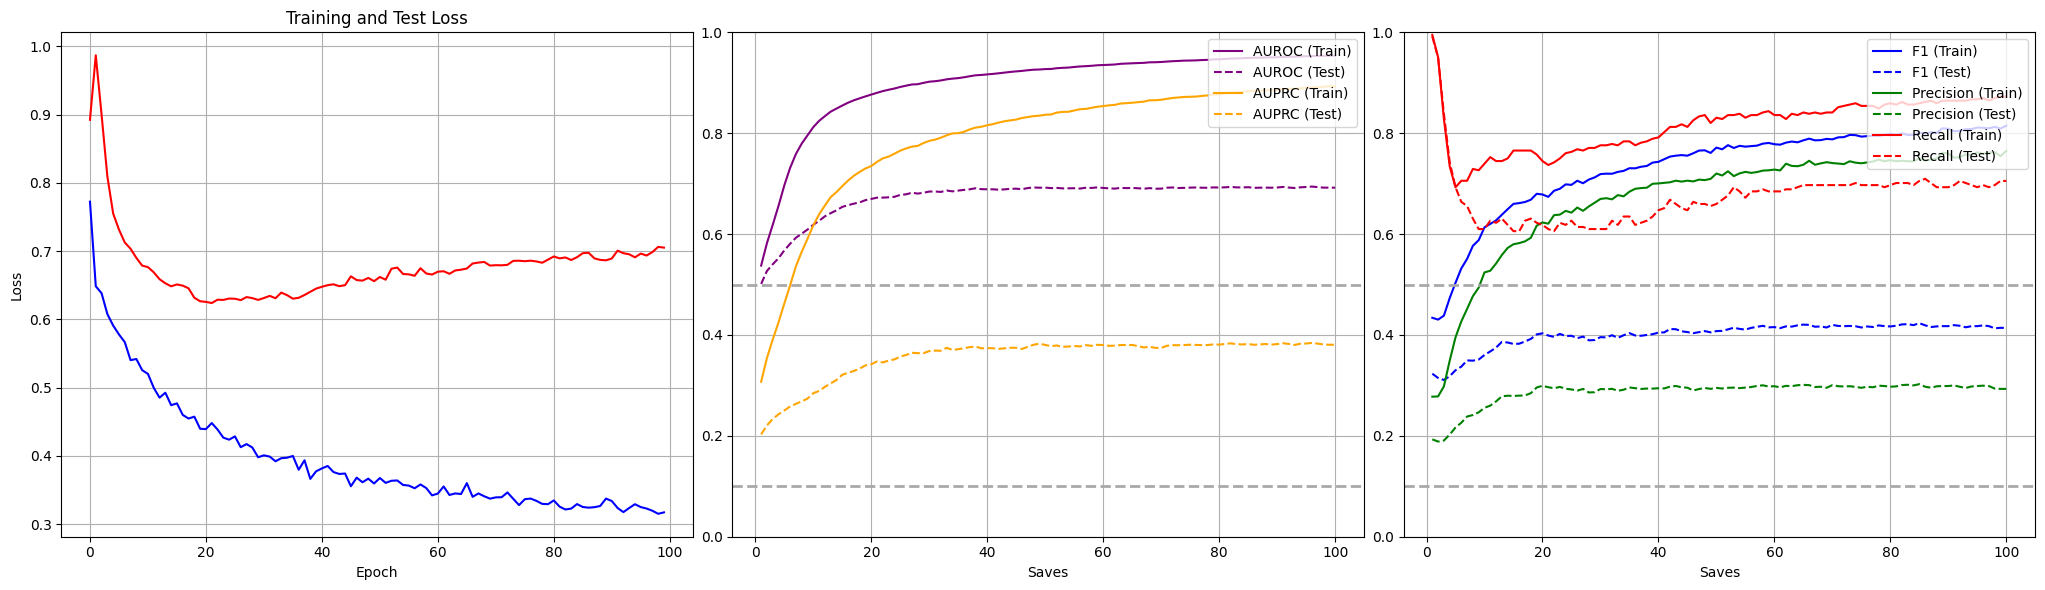

In [32]:
eval_dict_eng = eng_eval_metrics(eval_dic_tmp, binary=True)